# Preamble

In [1]:
# %%sh
# sudo apt install -y fonts-cmu texlive-latex-extra cm-super dvipng
# mkdir out

In [2]:
import copy
from typing import *
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import wandb
import wandb.apis

sns.set_context("paper", font_scale=1.5)
matplotlib.rc('font', **{'family': 'serif', 'serif': ["CMU Serif"]})
matplotlib.rc('text', usetex=True)
matplotlib.font_manager.findfont("CMU Serif", rebuild_if_missing=True)

api = wandb.Api()

findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.


In [21]:
def load_one(run: wandb.apis.public.Run) -> Dict[str, Any]:
    llama_eviction_bug_commits = {"12d9e3b7228c1e166f614f5acdd8a205e27236a4", "3f4fd0fa4f4b6bd119945c3e5f09028c1e569ca3"}
    if "count" in run.summary:
        task = run.config["task"]["name"]
        model = run.config["model"].split("/")[1].replace("-hf", "").replace("-v0.1", "").lower()
        mc = run.summary["model_config"]
        score_key = dict(
            squad="match",
            squad_train="match",
            triviaqa="match",
            cnn_dailymail="rougeL",
            wikitext_bpc="bpc",
            repetition="match_length_char",
        )[task]
        sparsity = copy.deepcopy(run.config["sparsity"])
        assert sparsity.pop("score", None) in [None, "sparse_q"]
        if sparsity["name"] == "eviction" and "llama" in model and run.commit in llama_eviction_bug_commits:
            return
        scores = [r[score_key] for r in run.summary["results"]]
        return dict(
            experiment=run.config["name"],
            task=task,
            confusion_contexts=run.config["task"].get("confusion_contexts"),
            wikitext_bugfix=run.config["code_changes"].get("forced-sample-no-specials", False),
            model=model,
            # n_heads=mc["num_attention_heads"] * mc["num_hidden_layers"],
            n_kv_heads=mc.get("num_key_value_heads", mc["num_attention_heads"]) * mc["num_hidden_layers"],
            head_size=mc["hidden_size"]//mc["num_attention_heads"],
            **sparsity,
            prefill_length=run.summary["prefill_length"],
            score=np.mean(scores),
            score_stderr=np.sqrt(np.var(scores) / len(scores)),
            id=run.id,
        )

def load_sweep(experiment_name: str, *single_runs: str) -> pd.DataFrame:
    return pd.DataFrame.from_dict(filter(None, (
        load_one(run)
        for run in api.runs(
            "research/sparse-attention", {"$or": [
                {"config.name": experiment_name},
                *({"display_name": n} for n in single_runs)
            ]}
        )
    )))

def memory_transfers_attention_only(s: pd.Series, count_kv: bool = True, count_index: bool = True) -> int:
    kv_elements, index_elements = 0, 0  # per-head
    if s["name"] == "dense":
        # write 1*(k, v) + read all prefill_length*(k, v)
        kv_elements = (2 + 2 * s["prefill_length"]) * s["head_size"]

    elif s["name"] == "sparse_v":
        # write 1*(k, v) + read all prefill_length*k + read sparse_k*v
        kv_elements = (2 + s["prefill_length"] + s["k"]) * s["head_size"]

    elif s["name"] == "local":
        # write 1*(k, v) + read sparse_k*v
        kv_elements = (2 + 2 * s["k"]) * s["head_size"]

    elif s["name"] == "eviction":
        # write 1*(k, v) + read all sparse_k*(k, v)
        kv_elements = (2 + 2 * s["k"]) * s["head_size"]
        # read/write scores
        index_elements = (1 + 2 * s["prefill_length"])

    elif s["name"] == "ann":
        # write 1*(k, v) + read all sparse_k*(k, v)
        kv_elements = (2 + 2 * s["k"]) * s["head_size"]
        # read/write index
        index_elements = s["head_size"] + s["prefill_length"] * s["rank"]
        if s["reallocate_to_mean_value"]:
            index_elements += 2 * s["head_size"]

    else:
        assert False, s["name"]

    return (count_kv * kv_elements + count_index * index_elements) * s["n_kv_heads"]

def add_dense_as_sparse(df: pd.DataFrame) -> pd.DataFrame:
    """Add 'dense' as if it were a sparse technique.
    Note that this only gives it the sparse 'name' string (not k, etc).
    """
    def _map(g: pd.DataFrame) -> pd.DataFrame:
        g_dense = g[g["name"]=="dense"]
        if len(g_dense) != 1:
            print(f"Warning: multiple dense results found for {g.task.iloc[0]}, {g.model.iloc[0]}", file=sys.stderr)
        return (g.groupby("name")
                .apply(lambda gg: gg if gg.name=="dense" else pd.concat([gg, g_dense.assign(name=gg.name)]))
                .reset_index(drop=True))
    return df.groupby(["task", "model"]).apply(_map).reset_index(drop=True)

palette = sns.color_palette()
name_to_hue = dict(dense=palette[4], ann=palette[0], eviction=palette[2], local=palette[3], sparse_v=palette[1])
name_to_label = dict(ann="SparQ Attention", eviction="H$_2$O", local="LM-Infinite", sparse_v="FlexGen (16-bit)")
name_to_marker = dict(dense=".", ann="o", eviction="X", local="^", sparse_v="P")

# Benchmarking

In [4]:
ipu_kernel_names = {
    "attn-local": "Dense (local SRAM)",
    "attn-remote": "Dense",
    "sparq-attn": "SparQ",
}
gpu_kernel_names = {
    "attn-torch": "Dense",
    "attn-mem-efficient": "Dense (ME)",
    "sparq-attn-triton-oneK": "SparQ ($K$ once)",
    "sparq-attn-compiled": "SparQ (plain)",
    "sparq-attn-triton": "SparQ",
}
def theoretical_bytes(s: pd.Series) -> int:
    dsize = dict(float16=2, float32=4)[s["dtype"]]
    if "sparq" in s.kernel:
        return dsize * s.n_head * (s.k1 * s.sequence_length + 2 * s.k2 * s.head_dim)
    return dsize * s.n_head * (2 * s.sequence_length * s.head_dim)

df = (pd.read_json("benchmarks.json")
    .pipe(lambda d: d.assign(
        duration=d.duration/d.batch_size,  # convert duration to per-query
        stderr_ratio=d.duration_stderr/d.duration,
        theoretical_bytes=d.apply(theoretical_bytes, axis=1),
        baseline=d.kernel.apply(lambda x: not ("sparq" in x or x == "attn-local")),
        device=d.device.apply(dict(ipu="ipu", cuda="gpu", cpu="cpu").__getitem__),
        device_name=d.device_name.apply(lambda n: {
            "M2000": "M2000",
            "NVIDIA A10G": "A10G",
            "NVIDIA A100-SXM4-40GB": "A100-40GB"
        }.get(n, n))
    ))
    .pipe(lambda d: d.assign(achieved_bandwidth=d.theoretical_bytes/d.duration))
    .groupby(["device_name", "sequence_length", "batch_size"])
        .apply(lambda d: d.assign(  # Speedup per batch size (not for best batch size)
            speedup=d[d.baseline].duration.min() / d.duration,
            theoretical_speedup=d[d.baseline].theoretical_bytes.min() / d.theoretical_bytes,
        ))
        .reset_index(drop=True)
    [["device", "device_name", "sequence_length", "batch_size",
      "kernel", "k1", "k2", "baseline", "theoretical_bytes", "theoretical_speedup",
      "duration", "stderr_ratio", "speedup", "achieved_bandwidth"]]
)

In [5]:
k1, k2 = 32, 128
sequence_length = 4096

batch_size = 64
print(f"GPU sequence_length={sequence_length}, batch_size={batch_size}, k1={k1}, k2={k2}")

display(df
    .pipe(lambda d: d[d.device == "gpu"])
    .pipe(lambda d: d[d.kernel.isin(["attn-torch", "attn-mem-efficient"]) | ((d.k1==k1) & (d.k2==k2))])
    .pipe(lambda d: d[~d.kernel.isin(["sparq-attn-torch-oneK", "sparq-attn-compiled-oneK", "sparq-attn-torch"])])
    .pipe(lambda d: d[d.batch_size == batch_size])
    .pipe(lambda d: d[d.sequence_length == sequence_length])
    .pipe(lambda d: d.assign(
        kernel=d.kernel.apply(gpu_kernel_names.__getitem__),
        result=d.apply(lambda x: f"{x.duration*1e6:.0f} us ({x.speedup:.2f})", axis=1),
        stderr_ratio=d.apply(lambda x: f"{x.stderr_ratio*100:.2f} %", axis=1),
    ))
    .pivot_table(index=["kernel"], columns="device_name", values=["result", "speedup", "theoretical_speedup", "stderr_ratio"], aggfunc="first")
    .swaplevel(axis=1)
    .sort_values(("A100-40GB", "speedup"))
    .drop(columns=[("A100-40GB", "speedup"), ("A10G", "speedup")])
)

sequence_length = 16384
batch_size = 1
print(f"IPU sequence_length={sequence_length}, batch_size={batch_size}, k1={k1}, k2={k2}")

display(df
    .pipe(lambda d: d[d.device == "ipu"])
    .pipe(lambda d: d[d.kernel.isin(["attn-remote", "attn-local"]) | ((d.k1==k1) & (d.k2==k2))])
    .pipe(lambda d: d[d.batch_size == batch_size])
    .pipe(lambda d: d[d.sequence_length == sequence_length])
    .pipe(lambda d: d.assign(
        kernel=d.kernel.apply(ipu_kernel_names.__getitem__),
        result=d.apply(lambda x: f"{x.duration*1e6:.0f} us ({x.speedup:.2f})", axis=1),
        stderr_ratio=d.apply(lambda x: f"{x.stderr_ratio*100:.2f} %", axis=1),
    ))
    .pivot_table(index=["kernel"], values=["result", "speedup", "theoretical_speedup", "stderr_ratio"], aggfunc="first")
    .sort_values("speedup")
    .drop(columns="speedup")
)

GPU sequence_length=4096, batch_size=64, k1=32, k2=128


device_name,A100-40GB,A10G,A100-40GB,A10G,A100-40GB,A10G
,result,result,stderr_ratio,stderr_ratio,theoretical_speedup,theoretical_speedup
kernel,,,,,,
Dense (ME),50 us (0.98),128 us (1.00),0.02 %,0.00 %,1.0,1.0
Dense,49 us (1.00),135 us (0.95),0.03 %,0.04 %,1.0,1.0
SparQ ($K$ once),38 us (1.28),79 us (1.63),0.27 %,0.04 %,6.4,6.4
SparQ (plain),37 us (1.33),78 us (1.65),0.73 %,0.02 %,6.4,6.4
SparQ,16 us (3.02),31 us (4.17),0.29 %,0.02 %,6.4,6.4


IPU sequence_length=16384, batch_size=1, k1=32, k2=128


,result,stderr_ratio,theoretical_speedup
kernel,,,
Dense,40432 us (1.00),0.00 %,1.000000
SparQ,5457 us (7.41),0.00 %,7.529412
Dense (local SRAM),134 us (302.34),0.00 %,1.000000


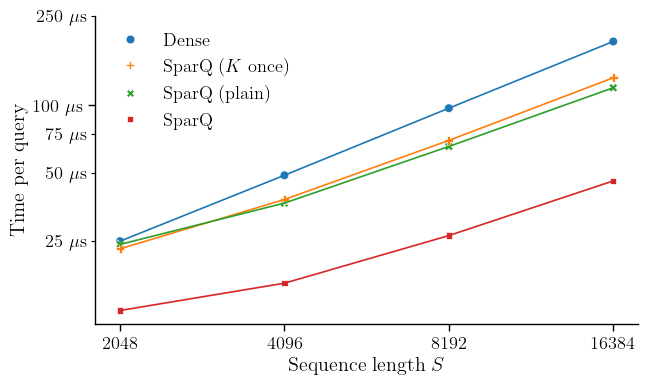

In [6]:
d = (df
    .pipe(lambda d: d[d.device_name == "A100-40GB"])
    .pipe(lambda d: d[d.kernel.isin(["attn-torch", "sparq-attn-compiled", "sparq-attn-triton-oneK", "sparq-attn-triton"])])
    .pipe(lambda d: d[d.kernel.isin(["attn-torch"]) | ((d.k1==32) & (d.k2==128))])
    .pipe(lambda d: d[d.batch_size == 64])
    .pipe(lambda d: d[d.sequence_length <= 16384])
    .pipe(lambda d: d.assign(kernel=d.kernel.apply(gpu_kernel_names.__getitem__)))
)

plt.figure(figsize=(7, 4))
hue_order = [k for k in gpu_kernel_names.values() if k in set(d.kernel)]
ax = sns.scatterplot(data=d, y="duration", x="sequence_length", hue="kernel", hue_order=hue_order, style="kernel", s=40)
sns.lineplot(data=d, y="duration", x="sequence_length", hue="kernel", hue_order=hue_order, legend=False)
ax.set_xscale("log", base=2)
ax.xaxis.set_major_formatter("{x:.0f}")
ax.set_yscale("log")
ax.legend(frameon=False)
ax.yaxis.set_major_formatter(lambda x, _: f"{x*1e6:.0f} $\mu$s")
ax.yaxis.set_minor_formatter(lambda x, _: f"{x*1e6:.0f} $\mu$s")
ax.set_xlabel("Sequence length $S$")
ax.set_ylabel("Time per query")
ax.set_yticks([25e-6, 50e-6, 75e-6, 250e-6], minor=True)
sns.despine(ax=ax)
plt.savefig(f"out/benchmark_a100_b64.pdf", bbox_inches="tight")

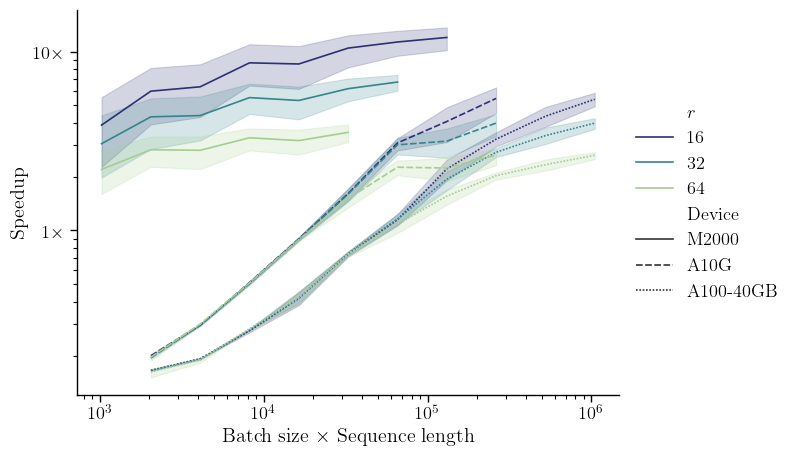

In [7]:
plt.figure(figsize=(7, 5))
ax = sns.lineplot(data=df
 .pipe(lambda d: d[d.kernel.isin(["sparq-attn", "sparq-attn-triton"])])
 .pipe(lambda d: d.assign(k1=d.k1.apply(int), k2=d.k2.apply(int), nelement=d.batch_size * d.sequence_length)),
    x="nelement", y="speedup", hue="k1", hue_norm=matplotlib.colors.LogNorm(),
    style="device_name", style_order=["M2000", "A10G", "A100-40GB"],
    palette="crest_r",
)
sns.despine(ax=ax)
ax.set_ylabel("Speedup")
ax.set_xlabel(r"Batch size $\times$ Sequence length")
ax.set_yscale("log")
ax.set_xscale("log")
ax.yaxis.set_major_formatter("${x:.0f}\\times$")
handles, labels = ax.get_legend_handles_labels()
labels[labels.index("k1")] = "$r$"
labels[labels.index("device_name")] = "Device"
ax.legend(handles, labels, loc="center left", bbox_to_anchor=(1.0, 0.5), frameon=False)
plt.savefig(f"out/benchmark_scaling.pdf", bbox_inches="tight");

# Scaling sequence length

In [8]:
df = (pd.concat([load_sweep("RMOE-78-long-context-v3")]).reset_index(drop=True)
    .pipe(lambda d: d.assign(transfers=d.apply(memory_transfers_attention_only, axis=1)))
    [["model", "confusion_contexts", "name", "k", "rank", "transfers", "prefill_length", "score", "score_stderr"]]
)

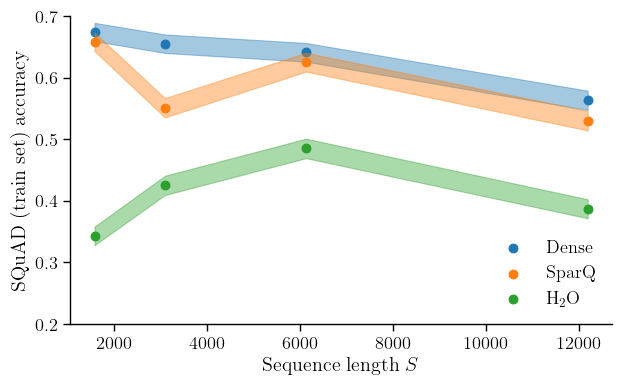

In [9]:
techniques = dict(
    dense="Dense",
    ann="SparQ",
    eviction="H$_2$O",
)
plt.figure(figsize=(7, 4))
ax = plt.gca()
for (name, label), color in zip(techniques.items(), sns.color_palette()):
    g = df[(df["name"] == name) & (df["confusion_contexts"] >= 7)].sort_values("prefill_length")
    ax.scatter(g.prefill_length, g.score, label=label, color=color, s=40)
    ax.fill_between(g.prefill_length, g.score - g.score_stderr, g.score + g.score_stderr,
                    alpha=.4, color=color)
ax.legend(frameon=False)
ax.set_xlabel("Sequence length $S$")
ax.set_ylabel("SQuAD (train set) accuracy")
ax.set_ylim((0.2, 0.7))
sns.despine(ax=ax)
plt.savefig(f"out/sequence_length_scaling.pdf", bbox_inches="tight")

# Main results (k=128, Llama 13B headline)

In [22]:
df = (
    pd.concat([
        # General
        load_sweep("RMOE-68-workshop-sweep").pipe(lambda d: d[d.model!="llama-2-13b"]),
        load_sweep("RMOE-68-lower-r"),
        load_sweep("RMOE-68-llama-7b-reruns-with-fix"),
        load_sweep("RMOE-71-ablations-main-sweep-top-k-sparse-attention"),
        # Llama 13B
        load_sweep("RMOE-77-larger-models-a100"),
        load_sweep("RMOE-77-larger-models-a100-rerun-wikitext"),
        load_sweep("RMOE-77-larger-models-a100-lower-r"),
        # Mistral
        load_sweep("RMOE-74-mistral-full-sweep"),
    ]).reset_index(drop=True)
    .pipe(lambda d: d.assign(transfers=d.apply(memory_transfers_attention_only, axis=1)))
    .pipe(lambda d: d[(d.task != "wikitext_bpc") | (~d.model.isin(["llama-2-13b", "llama-2-7b"])) | d.wikitext_bugfix])
    .pipe(lambda d: d[(d.name != "ann") | (d.k == 128)])
    .pipe(lambda d: d[d["rank"] != 12])
    .pipe(lambda d: d[(~d.name.isin(["eviction", "local"])) | (d.k >= 192)])
    [["task", "model", "name", "k", "rank", "transfers", "score", "score_stderr", "experiment", "id"]]
)
df

,task,model,name,k,rank,transfers,score,score_stderr,experiment,id
0,cnn_dailymail,llama-2-7b,eviction,768.0,NaN,2.043926e+08,0.218272,0.004589,RMOE-68-workshop-sweep,c6d39igx
1,cnn_dailymail,llama-2-7b,eviction,512.0,NaN,1.372838e+08,0.212692,0.004486,RMOE-68-workshop-sweep,hz39fc53
2,cnn_dailymail,llama-2-7b,eviction,384.0,NaN,1.037293e+08,0.208632,0.004424,RMOE-68-workshop-sweep,sfdhtbp9
3,cnn_dailymail,llama-2-7b,eviction,256.0,NaN,7.017490e+07,0.197323,0.003734,RMOE-68-workshop-sweep,ijckekgm
4,cnn_dailymail,llama-2-7b,eviction,192.0,NaN,5.339768e+07,0.187025,0.003796,RMOE-68-workshop-sweep,82e0zahq
...,...,...,...,...,...,...,...,...,...,...
807,wikitext_bpc,mistral-7b,dense,NaN,NaN,9.990229e+07,0.621060,0.005812,RMOE-74-mistral-full-sweep,ylkaxirt
808,repetition,mistral-7b,ann,128.0,64.0,4.115743e+07,209.468000,2.445682,RMOE-74-mistral-full-sweep,9p8lk5dd
810,repetition,mistral-7b,ann,128.0,32.0,2.482217e+07,207.304000,2.480633,RMOE-74-mistral-full-sweep,88h7bmft
812,repetition,mistral-7b,ann,128.0,16.0,1.665454e+07,201.111000,2.570386,RMOE-74-mistral-full-sweep,x3ne49pn


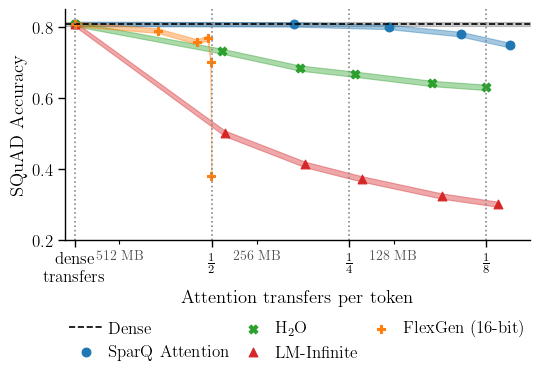

In [40]:
def show_tradeoff(model: str, task: str, title: bool, xlabel: bool, ylabel: bool, model_label: bool,
                  vlines: List[float], vlineslabel: bool,
                  ax: matplotlib.axes.Axes) -> None:
    g = add_dense_as_sparse(df[(df.model == model)&(df.task == task)])
    if not len(g[g.name=="dense"]):
        print(f"Cannot show {model}, {task}, as there is no dense baseline")
        return
    dense = g[g.name=="dense"].iloc[0]
    rmin, rmax = dict(
        squad=(.5, 1.05),
        cnn_dailymail=(.5, 1.05),
        triviaqa=(.5, 1.05),
        wikitext_bpc=(1.25, 1/1.025),
        repetition=(0, 1.1),
    )[task]
    score_min, score_max = dense.score * rmin, dense.score * rmax
    # transfers_min, transfers_max = dense.transfers * 1.05, dense.transfers / 8.5
    transfers_min, transfers_max = dense.transfers * 1.05, dense.transfers / 10
    lo = dense.score - dense.score_stderr
    hi = dense.score + dense.score_stderr
    ax.fill_between([transfers_min, transfers_max], [lo, lo], [hi, hi], color="k", alpha=.2)
    ax.hlines(dense.score, transfers_min, transfers_max, "k", linestyles="--", label="Dense")
    for ratio in vlines:
        ax.vlines(dense.transfers / ratio, 0, g.score.max() * 2, "k", linestyles=":", color="#888")

    for name, hue in name_to_hue.items():
        if name != "dense":
            d = g[g.name == name].sort_values("transfers")
            ax.fill_between(d.transfers, d.score - d.score_stderr, d.score + d.score_stderr, color=hue, alpha=.4)
            ax.scatter(d.transfers, d.score, color=hue, label=name_to_label[name], marker=name_to_marker[name], s=40)
    ax.set_xscale("log", base=2)
    ax.set_xlim((transfers_min, transfers_max))
    ax.set_ylim((score_min, score_max))
    ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=5, steps=[1,2,3,5,10]))
    if vlineslabel:
        assert vlines[0] == 1
        ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator([dense.transfers / ratio for ratio in vlines]))
        ax.tick_params(axis="x", which="minor", bottom=True, labelbottom=True, labelsize=10, labelcolor="#555")
        labels = ["dense\ntransfers"] + [f"$\\frac{{1}}{{{ratio}}}$" for ratio in vlines[1:]]
        ax.xaxis.set_major_formatter(lambda _, n: labels[n])
        ax.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=2))
        ax.xaxis.set_minor_formatter(lambda x, _: f"{x/2**20:.0f} MB" if 2**20 <= x else f"1/{1/(x/2**20):.0f} MB")
    else:
        ax.xaxis.set_major_formatter(lambda x, _: f"{x/2**20:.0f} MB" if 2**20 <= x else f"1/{1/(x/2**20):.0f} MB")
    if title:
        ax.set_title(model.capitalize().replace("b", "B").replace("-", " "), pad=12)
    if xlabel:
        ax.set_xlabel("Attention transfers per token")
    if model_label:
        ax.annotate(model, [transfers_min, score_min],
                    xytext=(5, 5), textcoords="offset points", va="bottom", ha="left", fontsize=12, alpha=.75)
    if ylabel:
        ax.set_ylabel(dict(squad="SQuAD Accuracy", cnn_dailymail="CNN/DailyMail ROUGE-L", triviaqa="TriviaQA Accuracy",
                           wikitext_bpc="WikiText-103 BPC", repetition="Repetition match length")[task])
    sns.despine(ax=ax)

sns.set_context("paper", font_scale=1.4)
plt.figure(figsize=(6, 3))
ax = plt.gca()
show_tradeoff("llama-2-13b", "squad", title=False, xlabel=True, ylabel=True, model_label=False, vlines=[1, 2, 4, 8], vlineslabel=True, ax=ax)
# ax.legend(frameon=False, bbox_to_anchor=(1.0, 0.5), loc="center left")
ax.legend(frameon=False, ncols=3, bbox_to_anchor=(0.0, -0.38, 1.0, 0.1), loc="upper center", handletextpad=0.3, columnspacing=0.3)
ax.set_ylim((0.2, 0.85))
plt.savefig(f"out/tradeoff_llama_squad.pdf", bbox_inches="tight")

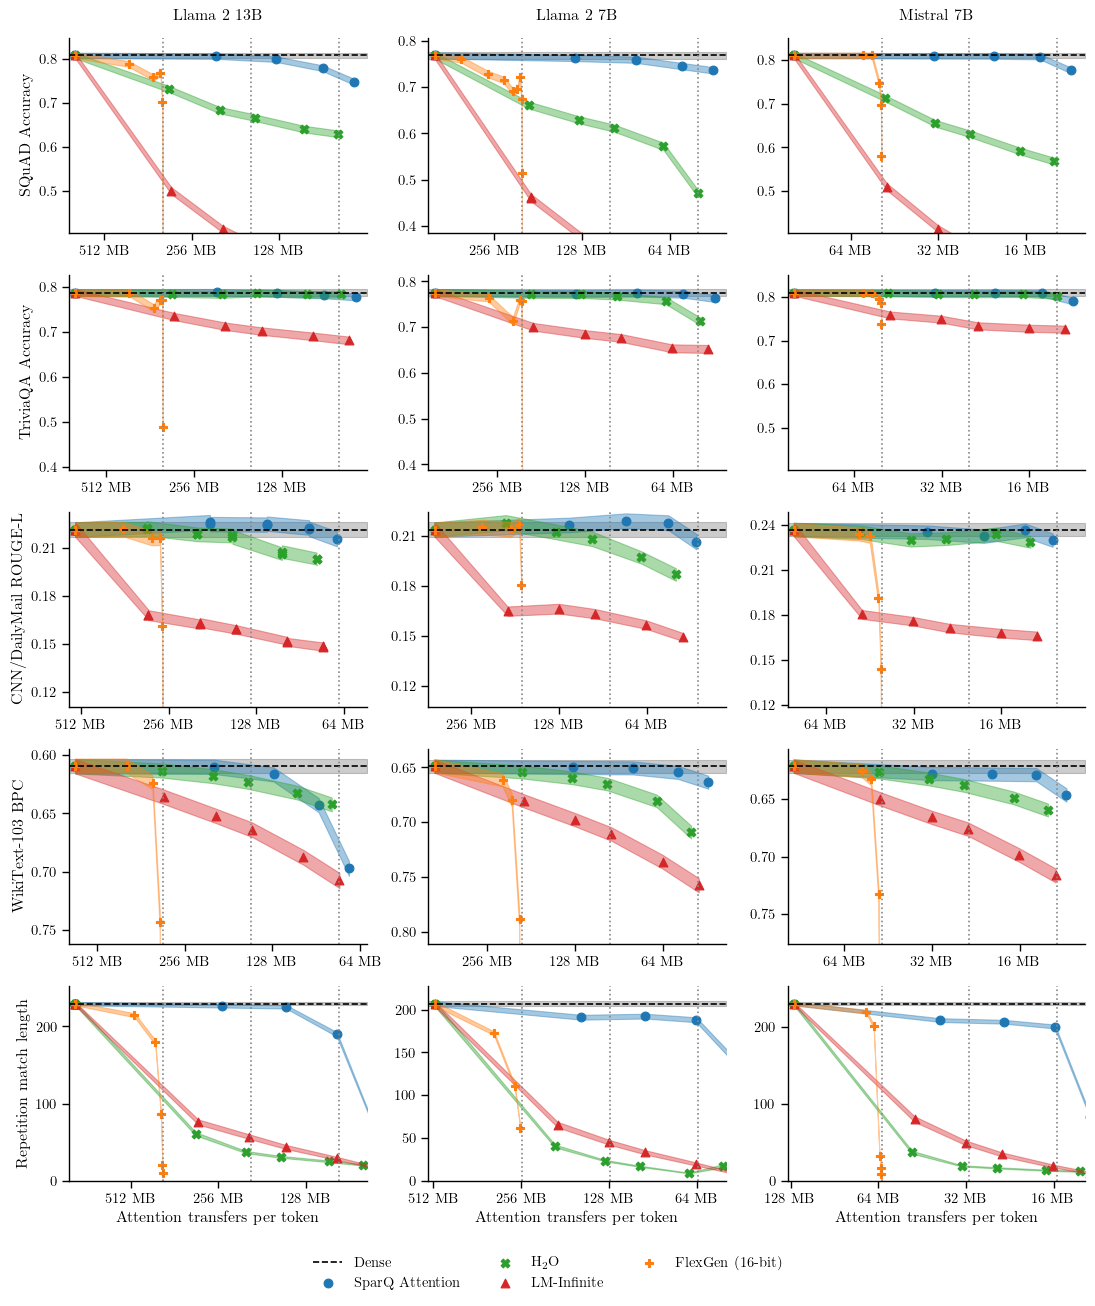

In [41]:
def show_tradeoffs(models: List[str], tasks: List[str], size: Tuple[float, float]) -> np.ndarray:
    fig, axs = plt.subplots(len(tasks), len(models), figsize=(size[0]*len(models), size[1]*len(tasks)), squeeze=False)
    for task, axr in zip(tasks, axs):
        for model, ax in zip(models, axr):
            show_tradeoff(model, task, title=(task == tasks[0]), xlabel=(task == tasks[-1]), ylabel=(model == models[0]),
                          model_label=False, vlines=[2, 4, 8], vlineslabel=False, ax=ax)
    plt.tight_layout(w_pad=0.5)
    fig.legend(*axs[0, 0].get_legend_handles_labels(), frameon=False,
               ncols=3, bbox_to_anchor=(0.0, -0.1, 1.0, 0.1), loc="upper center")
    return axs

sns.set_context("paper", font_scale=1.2)
show_tradeoffs(["llama-2-13b", "llama-2-7b", "mistral-7b"],
               ["squad", "triviaqa", "cnn_dailymail", "wikitext_bpc", "repetition"], (3.7, 2.5))
plt.savefig("out/tradeoff_grid.pdf", bbox_inches="tight")

## (Appendix) Run IDs for example outputs

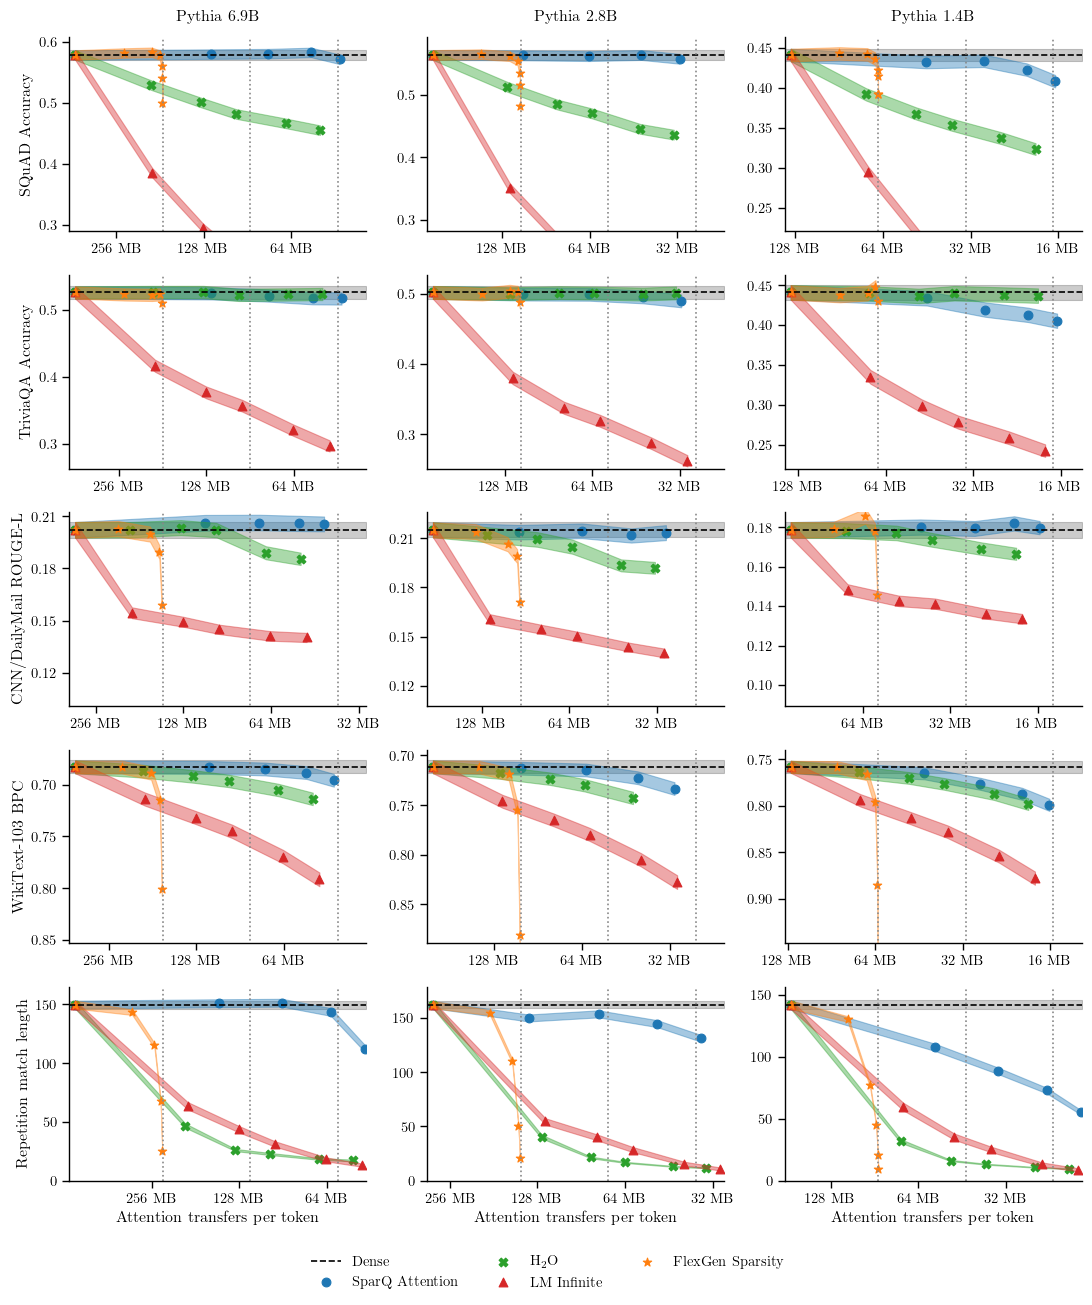

In [13]:
sns.set_context("paper", font_scale=1.2)
show_tradeoffs(["pythia-6.9b", "pythia-2.8b", "pythia-1.4b"],
               ["squad", "triviaqa", "cnn_dailymail", "wikitext_bpc", "repetition"], (3.7, 2.5))
plt.savefig("out/tradeoff_grid_pythia.pdf", bbox_inches="tight")

# Examples

In [14]:
for task, g in df.groupby("task"):
    print(task)
    display(g.pipe(lambda d: d[d.model == "llama-2-13b"])
    .pipe(lambda d: d[d.apply(lambda s: s["name"]=="dense" or (s["name"]=="ann" and s["rank"] == 8 and s["k"] == 128) or (s["name"] in ["eviction", "local"] and s["k"] == 192), axis=1)])
    .groupby("name").apply(lambda d: d.iloc[0])  # a few configs have multiple runs
    # .id
    # .transfers
    [["name", "transfers", "score"]]
    .sort_values("transfers")
    )

cnn_dailymail


,name,transfers,score
name,,,
ann,ann,70970726.4,0.215572
local,local,79052800.0,0.148762
eviction,eviction,83433881.6,0.202880
dense,dense,560983244.8,0.221399


repetition


,name,transfers,score
name,,,
local,local,79052800.0,18.282
ann,ann,79446784.0,74.781
eviction,eviction,85552896.0,21.004
dense,dense,832217088.0,229.388


squad


,name,transfers,score
name,,,
ann,ann,74489523.2,0.74850
local,local,79052800.0,0.30075
eviction,eviction,84313580.8,0.63000
dense,dense,673584742.4,0.80850


triviaqa


,name,transfers,score
name,,,
ann,ann,7.491809e+07,0.777741
local,local,7.905280e+07,0.681150
eviction,eviction,8.442072e+07,0.783757
dense,dense,6.872989e+08,0.787433


wikitext_bpc


,name,transfers,score
name,,,
ann,ann,73350272.0,0.697156
local,local,79052800.0,0.707453
eviction,eviction,84028768.0,0.642302
dense,dense,637128704.0,0.609574


In [15]:
{task: list(g
    .pipe(lambda d: d[d.model == "llama-2-13b"])
    .pipe(lambda d: d[d.apply(lambda s: s["name"]=="dense" or (s["name"]=="ann" and s["rank"] == 8 and s["k"] == 128) or (s["name"] in ["eviction", "local"] and s["k"] == 192), axis=1)])
    .groupby("name").apply(lambda d: d.iloc[0])  # a few configs have multiple runs
    .id
    )
for task, g in df.groupby("task")}

{'cnn_dailymail': ['jhtdsu6v', '3hdqdvcz', 'urvfe4ei', 'mut4eolt'],
 'repetition': ['9j21fmm7', 'tjca3tkr', '16ku5vpv', 'zubzr9ia'],
 'squad': ['e7v9cgwr', '0coy8ku5', '8fizgrac', '87whg2yy'],
 'triviaqa': ['zv7j4ilf', 'wwjvwthe', '8rr6ck8u', 'vswqd0gn'],
 'wikitext_bpc': ['l3ljj1h2', 'ulnw8eij', '37tikal9', 'mqeq0k3b']}